Import Libraries

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder,PolynomialFeatures
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

load data and Explore data

In [2]:
df=pd.read_csv('/content/train (3).csv')
print(df.head())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

importing custom matplotlib parameters for vizualizations

In [4]:
plt.rcParams['figure.figsize'] = (14,4)
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['figure.frameon'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams["font.family"] = "monospace";

# Color Palettes
colors = ["#bfd3e6", "#9b5b4f", "#4e4151", "#dbba78", "#bb9c55", "#909195","#dc1e1e","#a02933","#716807","#717cb4"]


In [5]:
#describe the data with some visual style by applying T = Transpose and style
df.describe().T.style.bar(subset=['mean'],color=colors[3]).background_gradient(subset=['std','50%','max'])

,count,mean,std,min,25%,50%,75%,max
Id,1460.000000,730.500000,421.610009,1.000000,365.750000,730.500000,1095.250000,1460.000000
MSSubClass,1460.000000,56.897260,42.300571,20.000000,20.000000,50.000000,70.000000,190.000000
LotFrontage,1201.000000,70.049958,24.284752,21.000000,59.000000,69.000000,80.000000,313.000000
LotArea,1460.000000,10516.828082,9981.264932,1300.000000,7553.500000,9478.500000,11601.500000,215245.000000
OverallQual,1460.000000,6.099315,1.382997,1.000000,5.000000,6.000000,7.000000,10.000000
OverallCond,1460.000000,5.575342,1.112799,1.000000,5.000000,5.000000,6.000000,9.000000
YearBuilt,1460.000000,1971.267808,30.202904,1872.000000,1954.000000,1973.000000,2000.000000,2010.000000
YearRemodAdd,1460.000000,1984.865753,20.645407,1950.000000,1967.000000,1994.000000,2004.000000,2010.000000
MasVnrArea,1452.000000,103.685262,181.066207,0.000000,0.000000,0.000000,166.000000,1600.000000
BsmtFinSF1,1460.000000,443.639726,456.098091,0.000000,0.000000,383.500000,712.250000,5644.000000


checking the target variables for distribution

/tmp/ipython-input-1687414575.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['SalePrice'],color=colors[7])


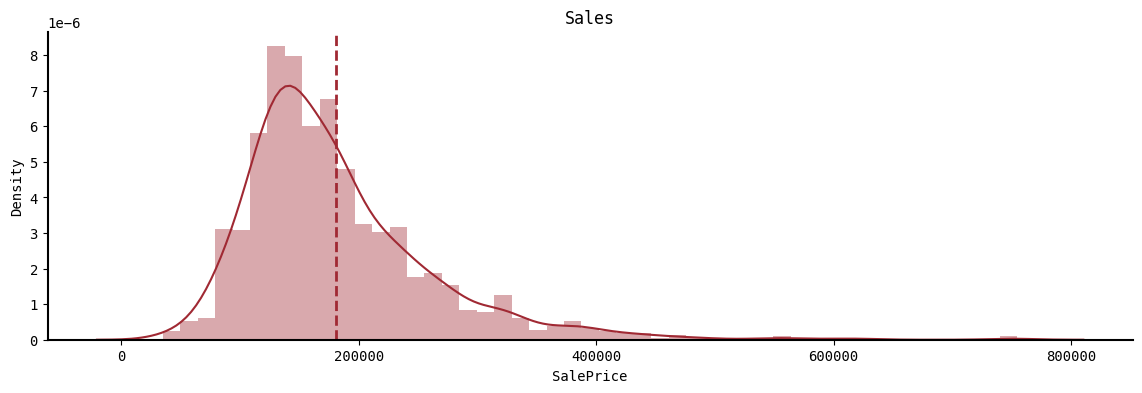

In [6]:

sns.distplot(df['SalePrice'],color=colors[7])
plt.axvline(x=df['SalePrice'].mean(), color=colors[7], linestyle='--', linewidth=2)
plt.title('Sales');

checking missing values

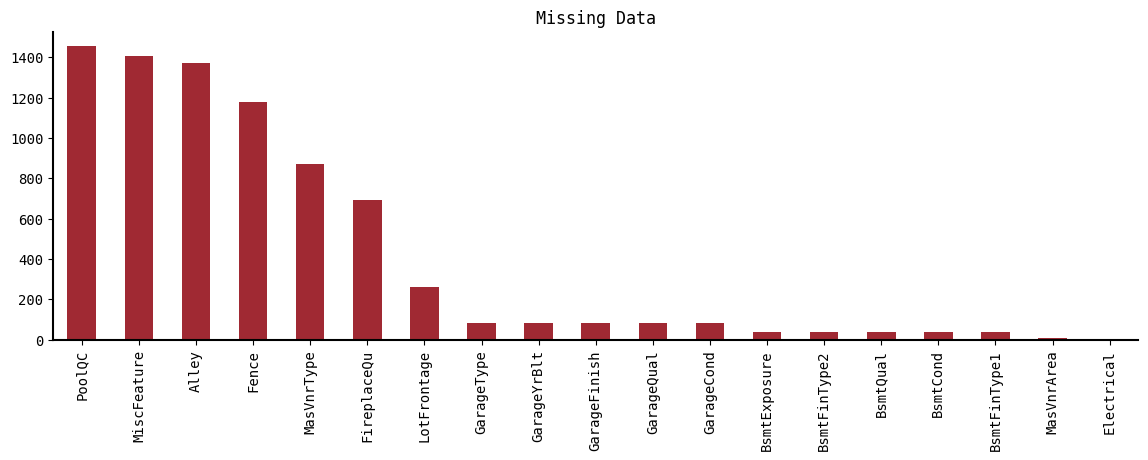

In [7]:
missing = df.isnull().sum()
missing = missing[missing > 0]
missing = missing.sort_values(ascending = False)
missing.plot.bar(color=colors[7])
plt.title('Missing Data');

‣ We can see that some of data got more than 50% missing data which is not good for training model.

‣ I will drop those values and for those who are less than 50% we will try to fill them.

Corelation

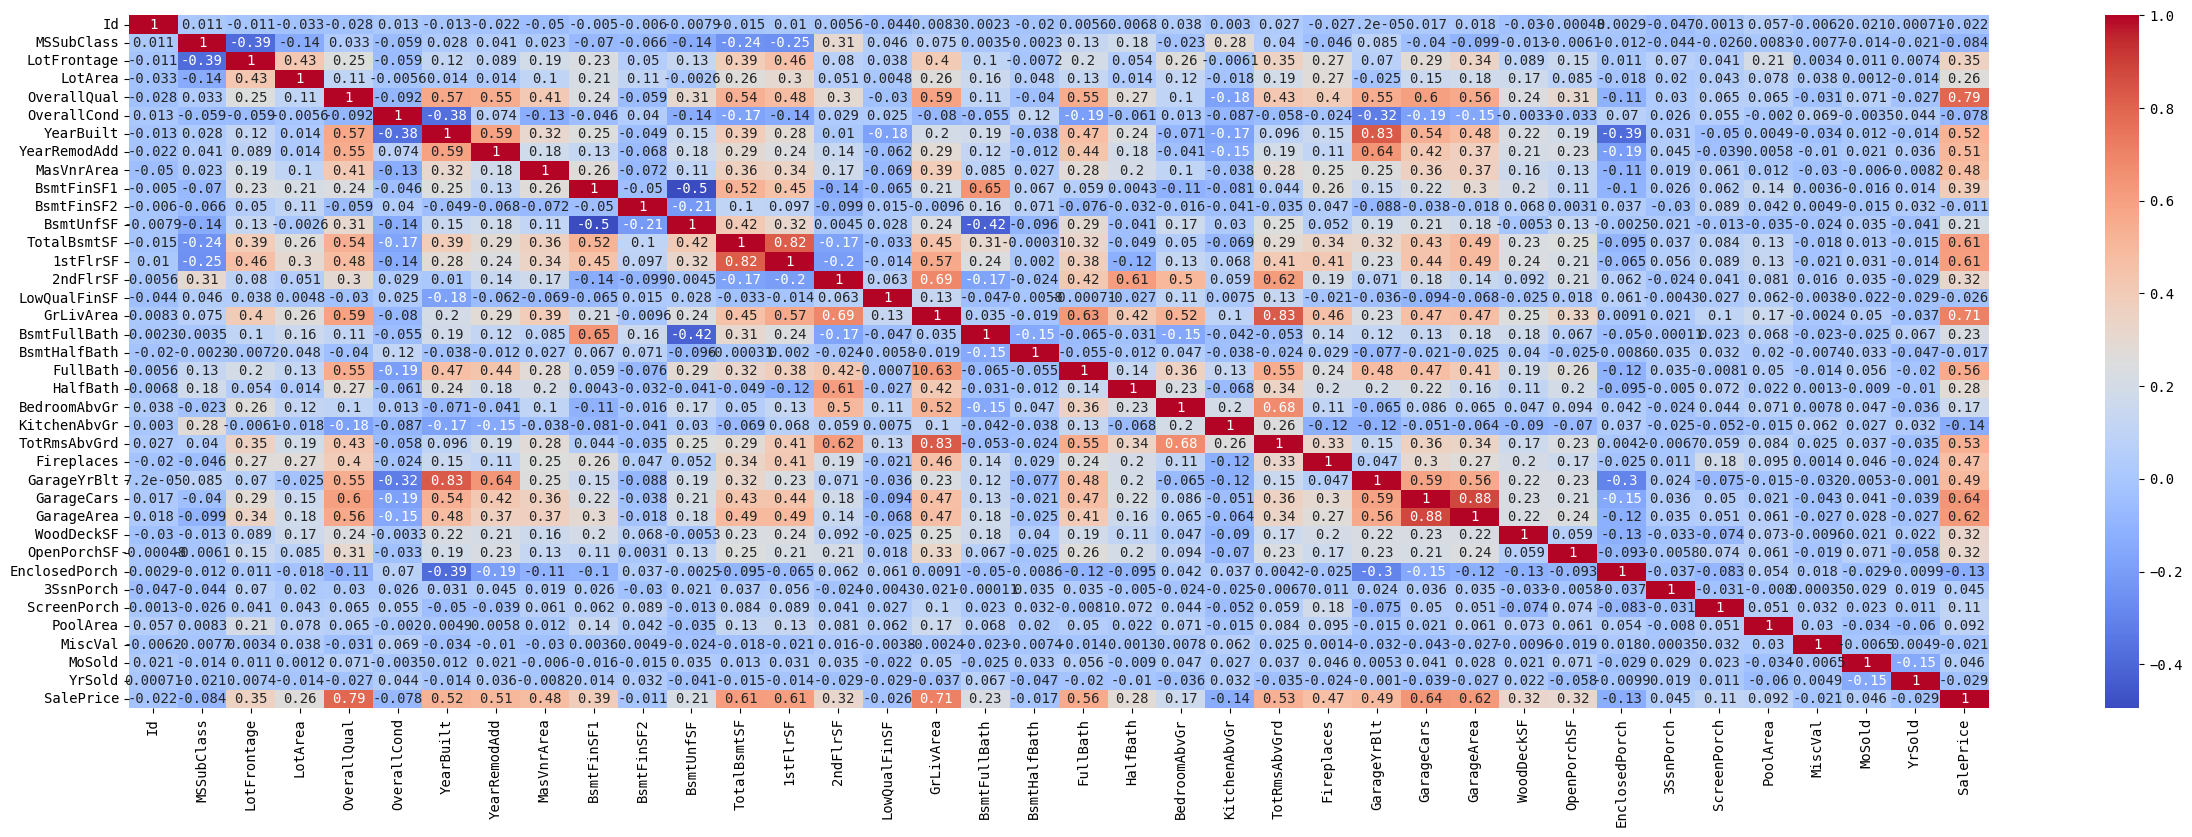

In [9]:
plt.figure(figsize=(30,9))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.show()


Handling Missing Data

In [10]:
df.drop(columns=["Id","Alley", "PoolQC", "Fence", "MiscFeature"], inplace=True)

none_cols = [
    "MasVnrType", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
    "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish",
    "GarageQual", "GarageCond"
]
for col in none_cols:
    df[col].fillna("None", inplace=True)

zero_cols = ["MasVnrArea", "GarageYrBlt"]
for col in zero_cols:
    df[col].fillna(0, inplace=True)

df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median())
)


/tmp/ipython-input-3641279486.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("None", inplace=True)
/tmp/ipython-input-3641279486.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.met

In [11]:
df.isnull().sum()

,0
MSSubClass,0
MSZoning,0
LotFrontage,0
LotArea,0
Street,0
...,...
MoSold,0
YrSold,0
SaleType,0
SaleCondition,0


In [12]:
df=df.drop_duplicates()

Feature Engineering

In [13]:
#house age
df["HouseAge"] = df["YrSold"] - df["YearBuilt"]
#total porch area
df["TotalPorchSF"] = df["OpenPorchSF"] + df["EnclosedPorch"] + df["3SsnPorch"] + df["ScreenPorch"]
#total number of bathrooms
df["TotalBaths"] = df["FullBath"] + (0.5 * df["HalfBath"]) + df["BsmtFullBath"] + (0.5 * df["BsmtHalfBath"])
#years since remodel
df["YearsSinceRemod"] = df["YrSold"] - df["YearRemodAdd"]
#interaction: Quality * Living area
df["QualGrLiv"] = df["OverallQual"] * df["GrLivArea"]
#is new house
df["IsNew"] = (df["YearBuilt"] == df["YrSold"]).astype(int)

features & target

In [15]:
X = df.drop(columns=["SalePrice"])
y = df["SalePrice"]

Split categorical & numerical

In [17]:
cat_cols = X.select_dtypes(include=["object"]).columns
num_cols = X.select_dtypes(exclude=["object"]).columns

Train-test split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Encode categorical

In [19]:
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_train_cat = encoder.fit_transform(X_train[cat_cols])
X_test_cat = encoder.transform(X_test[cat_cols])

Scale numerical

In [20]:
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[num_cols])
X_test_num = scaler.transform(X_test[num_cols])

Combine all features

In [21]:
X_train= np.hstack([X_train_num, X_train_cat])
X_test = np.hstack([X_test_num, X_test_cat])

Regression Models

In [23]:
models = {
    'SVR':SVR(),
    'XGBRegressor':XGBRegressor(),
    'Ridge':Ridge(),
    'ElasticNet':ElasticNet(),
    'SGDRegressor':SGDRegressor(),
    'BayesianRidge':BayesianRidge(),
    'LinearRegression':LinearRegression(),
    'RandomForestRegressor':RandomForestRegressor()
}

In [24]:
#taking results from the models
model_results = []
model_names = []

# training the model with function
for name,model in models.items():
    a = model.fit(X_train,y_train)
    predicted = a.predict(X_test)
    score = r2_score(y_test, predicted)
    model_results.append(score)
    model_names.append(name)

    #creating dataframe
    df_results = pd.DataFrame([model_names,model_results])
    df_results = df_results.transpose()
    df_results = df_results.rename(columns={0:'Model',1:'R2'}).sort_values(by='R2',ascending=False)

print(df_results)

                   Model        R2
6       LinearRegression  0.901665
2                  Ridge  0.894587
1           XGBRegressor  0.890231
4           SGDRegressor  0.886569
5          BayesianRidge  0.882273
7  RandomForestRegressor  0.877634
3             ElasticNet  0.839832
0                    SVR -0.023995


train best model

In [32]:

best_model = LinearRegression()
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R² Score:", r2)

R² Score: 0.9016647091207307


Training all data

In [34]:
train = df
test = pd.read_csv("/content/test020920251.csv")

target = "SalePrice"
X = train.drop(columns=[target])
y = train[target]


In [35]:
cat_cols = X.select_dtypes(include=["object"]).columns
num_cols = X.select_dtypes(exclude=["object"]).columns

Encoding & scaling

In [36]:
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
scaler = StandardScaler()

Train Processing

In [37]:
X_train_cat = encoder.fit_transform(X[cat_cols])
X_train_num = scaler.fit_transform(X[num_cols])
X_train_processed = np.hstack([X_train_num, X_train_cat])

Feature Engineering on Testing

In [38]:
test["HouseAge"] = test["YrSold"] - test["YearBuilt"]
test["TotalPorchSF"] = test["OpenPorchSF"] + test["EnclosedPorch"] + test["3SsnPorch"] + test["ScreenPorch"]
test["TotalBaths"] = test["FullBath"] + 0.5 * test["HalfBath"] + test["BsmtFullBath"] + 0.5 * test["BsmtHalfBath"]
test["YearsSinceRemod"] = test["YrSold"] - test["YearRemodAdd"]
test["QualGrLiv"] = test["GrLivArea"] * test["OverallQual"]
test["IsNew"] = (test["YearBuilt"] == test["YrSold"]).astype(int)


Test Processing

In [39]:
X_test_cat = encoder.transform(test[cat_cols])
X_test_num = scaler.transform(test[num_cols])
X_test_processed = np.hstack([X_test_num, X_test_cat])

Train linear regression

In [40]:
model=LinearRegression()
model.fit(X_train_processed,y)

LinearRegression()

prediction

In [52]:
X_test = pd.DataFrame(X_test_processed).dropna()
y_pred = model.predict(X_test)

saving predictions to csv

In [53]:
df_test_out = X_test.copy()
df_test_out["Predicted_SalePrice"] = y_pred
df_test_out.to_csv("predictions.csv", index=False)

In [54]:
p=pd.read_csv('/content/predictions.csv')
print(p.head())

          0         1         2         3         4         5         6  \
0 -0.872563  0.437043  0.110763 -0.795151  0.381743 -0.340077 -1.156380   
1 -0.872563  0.481637  0.375850 -0.071836  0.381743 -0.439440 -1.301740   
2  0.073375  0.169475  0.332053 -0.795151 -0.517200  0.852269  0.636400   
3  0.073375  0.347853 -0.054002 -0.071836  0.381743  0.885390  0.636400   
4  1.492282 -1.212959 -0.552407  1.374795 -0.517200  0.686666  0.345679   

          7         8         9  ...  283  284  285  286  287  288  289  290  \
0 -0.570750  0.053428  0.604293  ...  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0   
1  0.027027  1.051363 -0.288653  ...  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0   
2 -0.570750  0.761852 -0.288653  ...  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0   
3 -0.460051  0.347326 -0.288653  ...  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0   
4 -0.570750 -0.396190 -0.288653  ...  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0   

   291  Predicted_SalePrice  
0  0.0        114999.668731  
1  0.0  